In [1]:
# Import data science visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [34]:
# Set static vars and pathways
dir_data = r"data/"
file_noaa = "NOAA_LAX_Data.csv"
file_noaa_clean = "NOAA_LAX_Data_Clean.csv"

In [3]:
# Read data into pandas dataframe
df_noaa = pd.read_csv(dir_data + file_noaa)

In [4]:
def impute_null_precipitation(col):
        if col == 99.99:
            return 0.0
        else:
            return col

In [5]:
# Clean data, impute null values where possible and drop unused features
df_lax = df_noaa.loc[df_noaa['STN---'] == 722950]
df_lax.reset_index(inplace=True)
df_lax.columns = df_lax.columns.str.strip()
df_lax.drop(['Unnamed: 0', 'index', 'STN---', 'WBAN', '', '.1', '.2', '.3', '.4', '.5', 'Unnamed: 22', 'SNDP'], axis=1, inplace=True)
df_lax['YEARMODA'] = pd.to_datetime(df_lax['YEARMODA'], format='%Y%m%d')
df_lax['month'] = df_lax['YEARMODA'].apply(lambda date: date.month)
df_lax['year'] = df_lax['YEARMODA'].apply(lambda date: date.year)
df_lax['MAX'] = df_lax['MAX'].apply(lambda col: float(col.strip('*')))
df_lax['MIN'] = df_lax['MIN'].apply(lambda col: float(col.strip('*')))
df_lax['PRCP'] = df_lax['PRCP'].apply(lambda col: float(col[:-1].strip()))
df_lax['PRCP'] = df_lax['PRCP'].apply(impute_null_precipitation)
df_lax['d'] = 1

In [6]:
df_lax['FRSHTT'].value_counts()

0         10009
100000     4251
10000      1169
110000      958
10010       106
110010       61
10            8
10110         4
10100         4
110100        3
1             3
100010        2
110110        2
11000         2
111100        1
1000          1
111000        1
11110         1
110011        1
11100         1
Name: FRSHTT, dtype: int64

In [7]:
# Key for columns 'FRSHTT'
# 'FRSHTT': Indicators (1 = yes, 0 = no/not reported) for the occurrence during the day of:
# '000000': Sunny / Clear
# '100000': Fog
# '010000': Rain or Drizzle
# '001000': Snow or Ice Pellets
# '000100': Hail
# '000010': Thunder
# '000001': Tornado or Funnel Cloud

In [8]:
# Drop unused features for by-month analysis
df_lax = df_lax.drop(['SLP', 'STP', 'MXSPD', 'GUST', 'year', 'd', 'MAX', 'MIN'], axis=1).copy()

In [9]:
df_lax.head(3)

,YEARMODA,TEMP,DEWP,VISIB,WDSP,PRCP,FRSHTT,month
0,1973-01-01,58.6,12.9,25.9,8.7,0.0,0,1
1,1973-01-02,54.7,27.3,19.1,5.6,0.0,0,1
2,1973-01-03,53.3,42.4,22.1,7.1,0.0,10000,1


In [10]:
# Return subset query of sunny/clear days, foggy days, rainy days, and foggy+rainy days
df_lax_sfr = df_lax.query('FRSHTT == 0 | FRSHTT == 100000 | FRSHTT == 10000 | FRSHTT == 110000').copy()

In [11]:
# Transcribe weather event codes to str text
event_code = {0: "clear", 100000: "fog", 10000: "rain", 110000: "fog+rain"}
df_lax_sfr['FRSHTT'] = df_lax_sfr['FRSHTT'].map(event_code)

In [12]:
df_lax_sfr.set_index('YEARMODA', inplace=True)

In [13]:
# N-sizes by weather event for each daily observation 
df_lax_sfr['FRSHTT'].value_counts()

clear       10009
fog          4251
rain         1169
fog+rain      958
Name: FRSHTT, dtype: int64

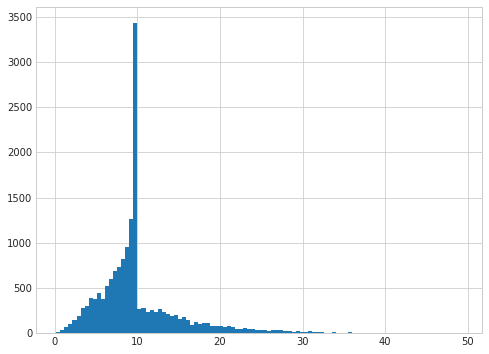

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=(8,6))
df_lax_sfr['VISIB'].hist(bins=100);

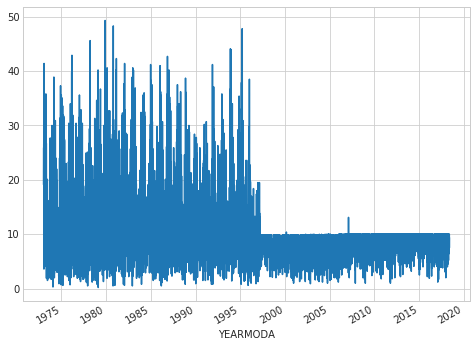

In [16]:
# Looks like around 1997-1998 the convention for measuring visibility was changed..
plt.figure(figsize=(8,6))
df_lax_sfr['VISIB'].plot();

In [17]:
# The international definition of fog is a visibility of less than 1 kilometre (3,300 ft); 
# mist is a visibility of between 1 kilometre (0.62 mi) and 2 kilometres (1.2 mi) and haze 
# from 2 kilometres (1.2 mi) to 5 kilometres (3.1 mi). (wikipedia.org)

# According to Wikipedia.org, fog forms when the differnce between temperature and 
# dew point is less than 2.5 degrees Celsius.

In [39]:
# Feature Engineering:
# Adjust visibility values: impose max of 10 miles. Also, new feature of 'fog' based on
# Visibility of less than 1.2 miles
def adjust_visibility_values(col):
    if col > 10:
        return 10
    else:
        return col

    
def fog_based_visibility(col):
    if col < 1.2:
        return 1
    else:
        return 0

    
df_lax_sfr['VISIB'] = df_lax_sfr['VISIB'].apply(adjust_visibility_values)
df_lax_sfr['FOG_VISIB'] = df_lax_sfr['VISIB'].apply(fog_based_visibility)

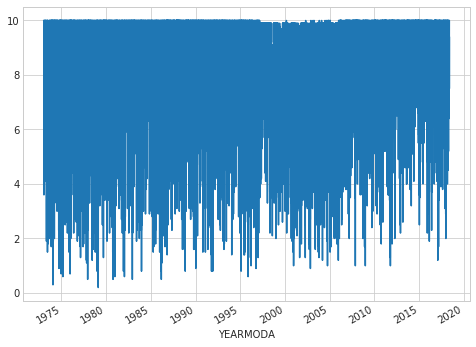

In [40]:
plt.figure(figsize=(8,6))
df_lax_sfr['VISIB'].plot();

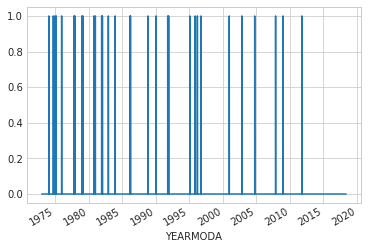

In [41]:
df_lax_sfr['FOG_VISIB'].plot()

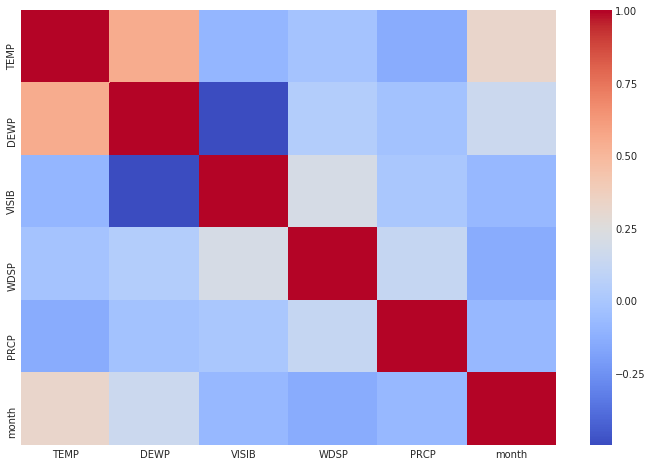

In [19]:
sns.set_style("whitegrid")

plt.figure(figsize=(12,8))
sns.heatmap(df_lax_sfr.corr(), cmap='coolwarm')

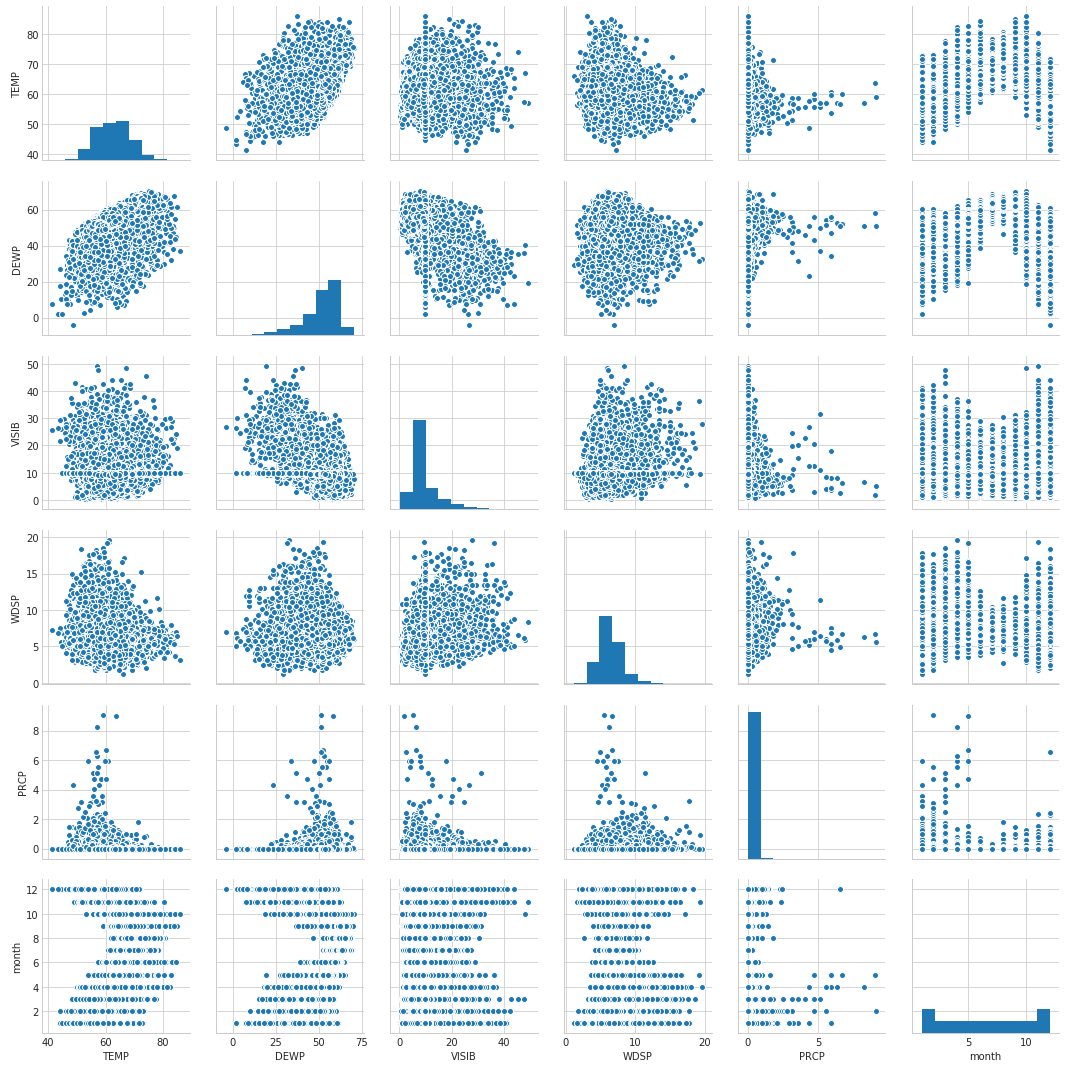

In [20]:
sns.pairplot(df_lax_sfr);

In [30]:
# Explore data: groupby month means
groupby_month_df_lax_sfr = df_lax_sfr.groupby('month').mean()

In [31]:
groupby_month_df_lax_sfr

,TEMP,DEWP,VISIB,WDSP,PRCP
month,,,,,
1,57.031841,42.636105,11.737100,5.539161,0.096752
2,57.405016,45.181975,11.581975,6.423119,0.117038
3,58.260014,47.854971,11.281988,6.961527,0.072954
4,60.156576,49.478766,11.052168,7.495738,0.041220
5,62.434253,53.660085,9.639137,7.248266,0.031769
6,65.322808,57.176820,9.064785,6.977489,0.003128
7,68.321186,60.522270,8.769125,6.974403,0.001793
8,69.077673,61.133237,8.728829,6.805925,0.004220
9,68.733559,59.947372,9.047898,6.423649,0.007523


In [ ]:
# Export cleaned dataset to csv for future use
df_lax_sfr.to_csv(dir_data + file_noaa_clean, columns=df_lax_sfr.columns)